In [1]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

#visual
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as mno
from imblearn.over_sampling import SMOTE

#learning
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, \
BayesianRidge, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

Using TensorFlow backend.


## Getting to Know the Data

In [2]:
# Loading data as pandas dataframe

# Naming the columns with attributes they represent
names = ['account_status', 'duration', 'credit_history',
             'purpose', 'credit_amount', 'savings_account', 'employment_since',
             'installment_rate', 'personal_status_sex', 'guarantors', 
             'residence_since', 'property', 'age', 'other_installment_plans',
             'housing', 'number_of_credits', 'job', 'people_to_maintain',
             'phone', 'foreign_worker', 'creditworthy']

df = pd.read_csv('data/kredit.dat', header=None, sep="\t", names=names)
# df = pd.read_csv('data/einkommen.train.txt', header=None, sep=",")
df.shape

(1000, 21)

In [3]:
# Last column is the target variable
df.creditworthy.replace([1,2], [1,0], inplace=True)
label = df['creditworthy']
df = df.drop(columns=['creditworthy'])
df.shape

(1000, 20)

In [4]:
# Getting familiar with data

print(f'Number of data points: {df.shape[0]}')
print(f'Number of Attributes: {df.shape[1]}')
df.head(5)

Number of data points: 1000
Number of Attributes: 20


,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,36,A32,?,2299,A63,?,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,?
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,?,1,A191,A201
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,?,2,A191,?
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201


In [5]:
# Explore types of data in dataset
print(df.dtypes)

account_status             object
duration                    int64
credit_history             object
purpose                    object
credit_amount               int64
savings_account            object
employment_since           object
installment_rate            int64
personal_status_sex        object
guarantors                 object
residence_since             int64
property                   object
age                         int64
other_installment_plans    object
housing                    object
number_of_credits           int64
job                        object
people_to_maintain          int64
phone                      object
foreign_worker             object
dtype: object


In [6]:
# As we see above: 2 data types
# Features will be treated separately

def categorical_numerical_split(df):
    categorical = [att for att in df.columns if df[att].dtype == 'object']
    numerical = [att for att in df.columns if np.issubdtype(df[att].dtype, np.number) ]
    return categorical, numerical

categorical, numerical = categorical_numerical_split(df)

print(f'Categorical features:\n{categorical}\n')
print(f'Numerical features:\n{numerical}')

Categorical features:
['account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'phone', 'foreign_worker']

Numerical features:
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'number_of_credits', 'people_to_maintain']


In [7]:
# Change a yes/no categorical varibable into numeric one
df.replace('A201', 1, inplace=True)
df.replace('A202', 0, inplace=True)
df.replace('A191', 0, inplace=True)
df.replace('A192', 1, inplace=True)

#Rescale
df.credit_amount = np.log(df.credit_amount)

### 2.2 Handling Missing Values

NaN in Pandas:
1. Nan != NaN (whereas None == None)  
2. When summing data, NaN values will be treated as zero.   
If the data are all NA, the result will be 0.  



In [8]:
# For more convenient operations for missing values, replace ? with NaN
# As we see, there are too many missing values to remove these points from the dataset
df.replace("?", np.nan, inplace=True)

In [9]:
print(f'Number of Missing Values:\n\n{df.isnull().sum()}')

Number of Missing Values:

account_status               0
duration                     0
credit_history               0
purpose                    173
credit_amount                0
savings_account              0
employment_since           496
installment_rate             0
personal_status_sex          0
guarantors                   0
residence_since              0
property                     0
age                          0
other_installment_plans      0
housing                      0
number_of_credits            0
job                        232
people_to_maintain           0
phone                        0
foreign_worker             360
dtype: int64


In [10]:
# Grab missing columns
missing_columns = ['purpose', 'employment_since', 'job', 'foreign_worker']

# create df with features that are fully available
df_X = df.dropna(axis=1, how='any')
print(f'Comparing the data frame with all featrues {df.shape}')
print(f'to the one with with columns where no featrues ar emissing {df_X.shape} ')

Comparing the data frame with all featrues (1000, 20)
to the one with with columns where no featrues ar emissing (1000, 16) 


In [11]:
# Percentage of missing values
df[missing_columns].isnull().sum()/len(df)

purpose             0.173
employment_since    0.496
job                 0.232
foreign_worker      0.360
dtype: float64

Purpose - 17.3%.   
Employment since - 49.6%  
job - 0.23%.   
foreign worker - 36%. 

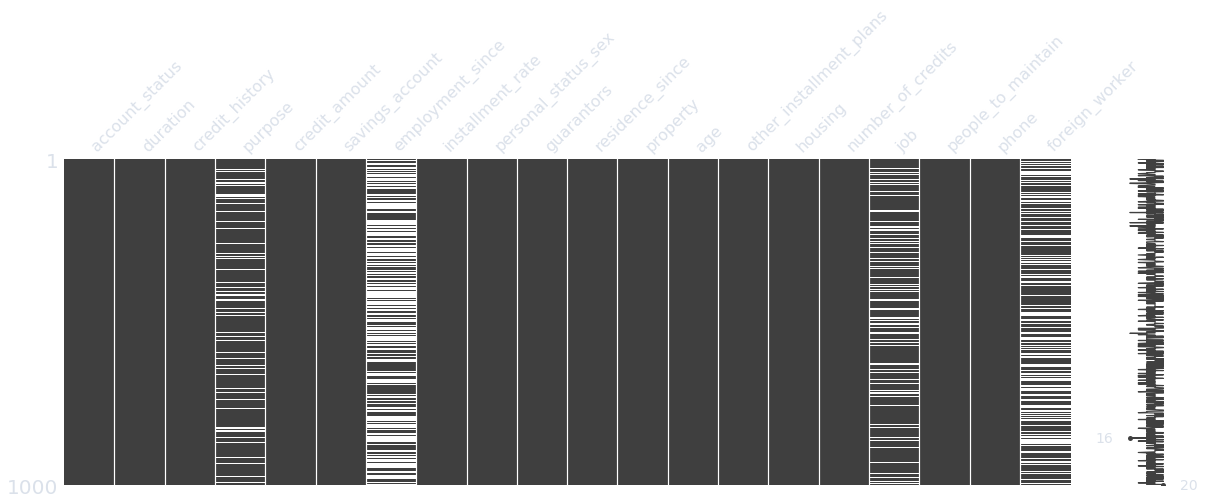

In [12]:
mno.matrix(df, figsize = (20, 6))

In [13]:
#pd.crosstab(label, df['credit_history'])

There are many options we could consider when replacing a missing value, for example:

- A constant value that has meaning within the domain, such as 0, distinct from all other values.  
- A value from another randomly selected record.  
- A mean, median or mode value for the column.  
- A value estimated by another predictive model. 

Prediction model is one of the sophisticated method for handling missing data. Here, we create a predictive model to estimate values that will substitute the missing data.  In this case, we divide our data set into two sets: One set with no missing values for the variable and another one with missing values. First data set become training data set of the model while second data set with missing values is test data set and variable with missing values is treated as target variable. Next, we create a model to predict target variable based on other attributes of the training data set and populate missing values of test data set.

In [14]:
print(df.shape)
# Dropping not an option: too much data lost
print(df.dropna().shape)
#no data points withh all values missing
print(df.dropna(how='all').shape)
# ?? maybe it makes sense to remove data points with many missing things
print(df.dropna(subset=['purpose', 'foreign_worker', 'employment_since'], how='all').shape)
# print(df.purpose.value_counts(dropna=False))

(1000, 20)
(203, 20)
(1000, 20)
(969, 20)


## 2. Data Pre-Processing

### 2.1 Feature Representation

#### 2.1.1 Numerical

In [15]:
# Ranges of values 
def display_range(df, numerical):
    for pos in range(len(numerical)):
        print(f'{numerical[pos]} : {df[numerical[pos]].min()} - {df[numerical[pos]].max()}')

In [16]:
display_range(df, numerical)

duration : 4 - 72
credit_amount : 5.521460917862246 - 9.82140944150052
installment_rate : 1 - 4
residence_since : 1 - 4
age : 19 - 75
number_of_credits : 1 - 4
people_to_maintain : 1 - 2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4608c780>,
      dtype=object)

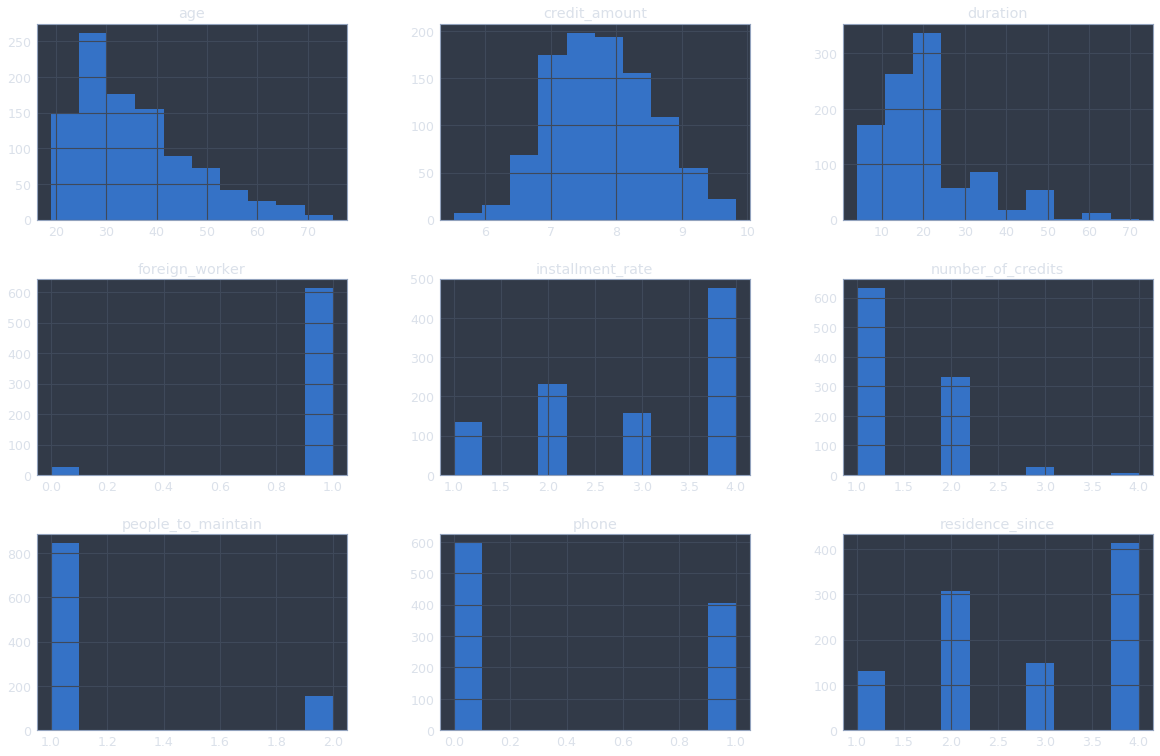

In [17]:
# As we see, the scales are very different, so we will have to normalize the data
df.hist(figsize = (20,13))

In [18]:
# Normalize all numerical attributes
def zscore(x):
    #assert isinstance(x,np.ndarray), "x must be a numpy array"
    return (x-np.mean(x)) / np.std(x)

In [19]:
df = df.apply(lambda x: zscore(x) if x.dtype == 'int64' else x)
# df_X_normalized = df_X.apply(lambda x: zscore(x) if x.dtype == 'int64' else x)
# df.hist(figsize = (20,13))
df.head()

,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,1.252574,A32,NaN,7.740230,A63,NaN,0.918477,A93,A101,1.046987,A123,0.303788,A143,A152,-0.704926,A173,-0.428290,-0.823318,NaN
1,A12,-0.240857,A32,A46,7.122060,A65,A73,0.918477,A93,A101,1.046987,A124,2.238742,A143,A153,-0.704926,NaN,-0.428290,-0.823318,1.0
2,A13,0.256953,A32,A40,6.853299,A61,A74,0.918477,A93,A101,0.140505,A124,0.215835,A141,A153,-0.704926,NaN,2.334869,-0.823318,NaN
3,A14,-0.489762,A33,A43,7.298445,A61,A73,0.918477,A94,A101,0.140505,A121,-0.223927,A141,A152,1.027079,A173,-0.428290,-0.823318,1.0
4,A14,0.256953,A32,A40,7.329750,A64,A74,0.918477,A92,A101,0.140505,A123,-0.135974,A143,A152,-0.704926,A173,2.334869,1.214598,1.0


In [20]:
display_range(df, numerical)

duration : -1.4024146328950455 - 4.239435632552691
credit_amount : 5.521460917862246 - 9.82140944150052
installment_rate : -1.7645135849361222 - 0.9184771676276725
residence_since : -1.6724592395536915 - 1.0469866784197903
age : -1.4552613021409855 - 3.4700761159597757
number_of_credits : -0.704925998389089 - 4.491088731751615
people_to_maintain : -0.4282895663715421 - 2.3348689263480837


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a450c6668>,
      dtype=object)

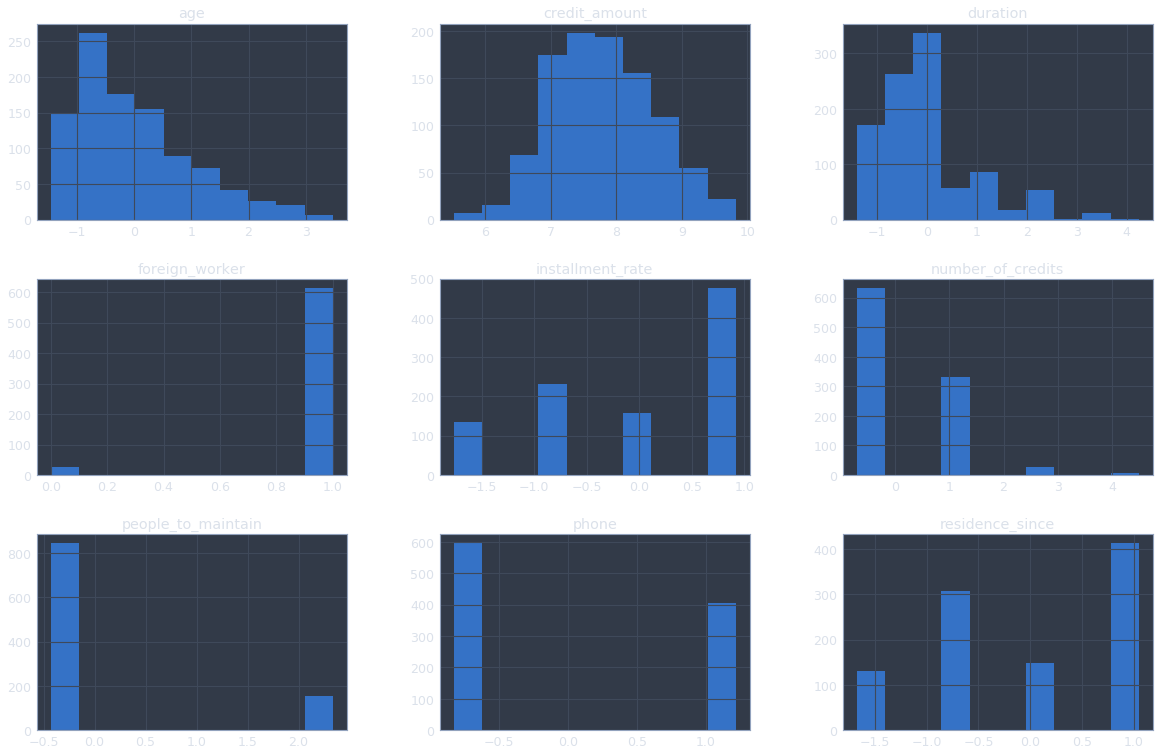

In [21]:
df.hist(figsize = (20,13))

#### 2.1.2 Categorical


In [22]:
# Columns without missing values = X, columns with missing values become y one by one

In [23]:
# Show how many unique categorical values we have: useful for one-hot encoding
df[categorical].nunique()

account_status              4
credit_history              5
purpose                    10
savings_account             5
employment_since            5
personal_status_sex         4
guarantors                  3
property                    4
other_installment_plans     3
housing                     3
job                         4
phone                       2
foreign_worker              2
dtype: int64

In [24]:
# Feature representation

print("Unique categorical values:")
for att in df.select_dtypes(include=[object]):
    print(att,":", df[att].unique())
    
# We will have to represent features differently 

Unique categorical values:
account_status : ['A14' 'A12' 'A13' 'A11']
credit_history : ['A32' 'A33' 'A34' 'A30' 'A31']
purpose : [nan 'A46' 'A40' 'A43' 'A41' 'A42' 'A49' 'A410' 'A45' 'A48' 'A44']
savings_account : ['A63' 'A65' 'A61' 'A64' 'A62']
employment_since : [nan 'A73' 'A74' 'A75' 'A72' 'A71']
personal_status_sex : ['A93' 'A94' 'A92' 'A91']
guarantors : ['A101' 'A102' 'A103']
property : ['A123' 'A124' 'A121' 'A122']
other_installment_plans : ['A143' 'A141' 'A142']
housing : ['A152' 'A153' 'A151']
job : ['A173' nan 'A174' 'A172' 'A171']


In [25]:
def str_to_num(df):
    ''' Encodes nominal features to numeric features 
    return: data frame with all-numeric features, a dict to decode '''
    

    # create a new df with categorical features only, encoded as numbers
    categorical, numerical = categorical_numerical_split(df)
    
    enc = LabelEncoder()
    df_encoded = df[categorical].apply(lambda x: enc.fit_transform(x))

    df_encoded_concat = pd.concat([df_encoded, df[numerical]], axis=1)
    
    # Create a dict to decode numeric values
    d = defaultdict()
    for col_name in df[categorical]:
        # e.g.: account_status_A14 :  3
        for unique_str_val, unique_num_val in zip(
            df[col_name].unique(), df_encoded[col_name].unique()):
                d[col_name + '_' + unique_str_val] = unique_num_val
                
#         d[col_name] = df_encoded[]
    
    return df_encoded_concat , d


In [26]:
df_X_enc, df_X_enc_dict = str_to_num(df_X)

# Print out new numericaly encoded features
for k,v in df_X_enc_dict.items():
    print(k, ': ', v)


account_status_A14 :  3
account_status_A12 :  1
account_status_A13 :  2
account_status_A11 :  0
credit_history_A32 :  2
credit_history_A33 :  3
credit_history_A34 :  4
credit_history_A30 :  0
credit_history_A31 :  1
savings_account_A63 :  2
savings_account_A65 :  4
savings_account_A61 :  0
savings_account_A64 :  3
savings_account_A62 :  1
personal_status_sex_A93 :  2
personal_status_sex_A94 :  3
personal_status_sex_A92 :  1
personal_status_sex_A91 :  0
guarantors_A101 :  0
guarantors_A102 :  1
guarantors_A103 :  2
property_A123 :  2
property_A124 :  3
property_A121 :  0
property_A122 :  1
other_installment_plans_A143 :  2
other_installment_plans_A141 :  0
other_installment_plans_A142 :  1
housing_A152 :  1
housing_A153 :  2
housing_A151 :  0


In [27]:
# Make sure there are still 16 feature
print(df_X_enc.shape)

(1000, 16)


In [28]:
def to_one_hot(df, verbose=False):
    '''Encodes specified columns of a dataframe as one-hot vectors
    
    df: dataframe 
    to_onehot: list of columns to encode
    
    Returns encoded df
    '''
    
    categorical, numerical = categorical_numerical_split(df)
    
    # 1-hot encoding for the categorical variables
    df_only_one_hot = pd.get_dummies(df[categorical])
    
    if verbose == True:
        print('new 1-hot-encoded variables:\n {}'.format(list(df_only_one_hot.columns)))
    
    # Concatenate numerical and categorical data
    df_X_onehot = pd.concat([df[numerical], df_only_one_hot], axis = 1)
    
    if verbose == True:
        print(f'Shape: {df_X_onehot.shape}')
        df_X_onehot.head()
    
    return df_X_onehot

In [29]:
# Fatures that shoud be encoded for X_train
df_X_onehot = to_one_hot(df_X, verbose=True)

new 1-hot-encoded variables:
 ['account_status_A11', 'account_status_A12', 'account_status_A13', 'account_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'savings_account_A61', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65', 'personal_status_sex_A91', 'personal_status_sex_A92', 'personal_status_sex_A93', 'personal_status_sex_A94', 'guarantors_A101', 'guarantors_A102', 'guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installment_plans_A141', 'other_installment_plans_A142', 'other_installment_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153']
Shape: (1000, 39)


### How balanced is the dataset?

1    700
0    300
Name: creditworthy, dtype: int64


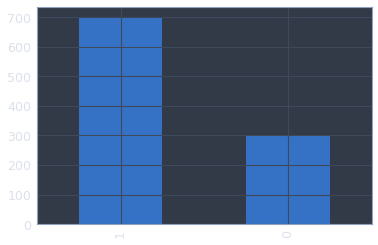

In [30]:
# 1 = good, trustworthy
# 0 = bad, Not trustworthy
print(label.value_counts())

label.value_counts().plot(kind='bar', label= 'Target Values')
# There are more than twice as many creditworthy examples

### Balancing the Dataset  
1. Oversampling: It is the process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class. The most common technique is called SMOTE (Synthetic Minority Over-sampling Technique). In simple terms, it looks at the feature space for the minority class data points and considers its k nearest neighbours.

[CBHK2002]	(1, 2) N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 16, 321-357, 2002.

In [31]:
def balance_data(df,label):
    sm = SMOTE(sampling_strategy='minority', random_state=7)

    # Fit the model to generate the data.
    cols = df.columns
    df, label = sm.fit_sample(df, label)
    df = pd.DataFrame(df)
    label = pd.Series(label)
    # oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
    df.columns = cols
    return df,label

In [32]:
# df_to_balance_enc = pd.concat([df_X_enc, df[missing_columns]], axis=1)
# df_to_balance_onehot = pd.concat([df_X_onehot, df[missing_columns]], axis=1)

1    700
0    700
dtype: int64


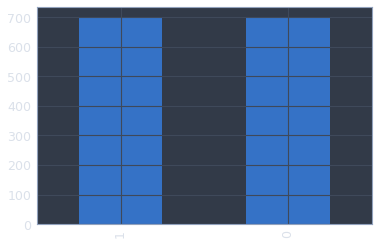

In [33]:
label_orig = label
df_X_enc, label_enc = balance_data(df_X_enc,label_orig)
df_X_onehot, label_onehot = balance_data(df_X_onehot, label_orig)

# 1 = good, trustworthy
# 0 = bad, Not trustworthy
print(label_enc.value_counts())

label_enc.value_counts().plot(kind='bar', label= 'Target Values')
# There are more than twice as many creditworthy examples

1    700
0    700
dtype: int64
(1400, 39)


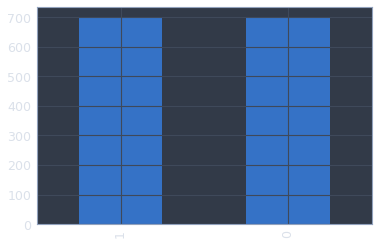

In [34]:
print(label_enc.value_counts())

print(df_X_onehot.shape)
label_onehot.value_counts().plot(kind='bar', label= 'Target Values')

### Evaluation

Aim: how many people out of those who thought werr trustworthy, were actually trustworthy

Aim: reduce the number of false positives, to increase precision  
Note: A model that produces no false positives has a precision of 1.0.

![]()

In [35]:
# Function for evaluation reports
def cross_validate(clf, X_train, y_train, metrics=['precision', 'accuracy']):
    ''' 10-fold Cross Validation on training and validation data 
        Nothing to return '''

#     metrics = ['precision', 'accuracy'] #, 'f1_micro'
    for metric in metrics: 
        scores = cross_val_score(clf, X_train, y_train, cv=10, scoring=metric)
        
        # The mean score and standard deviation of the score estimate
        print("Cross Validation %s: %0.2f (+/- %0.2f)" % (metric, scores.mean(), scores.std()))
    
    return 

def train(clf, X_train, y_train):
    '''Fits classifier'''
    print(f'Training a {clf.__class__.__name__} with a training set size of {len(X_train)}')
    clf.fit(X_train, y_train)
    return clf


def predict(clf, X_test):    
    ''' Predict on unseen test data 
        Return predicted labels '''
    y_pred = clf.predict(X_test)
    return y_pred


def evaluate_test(y_test, y_pred):
    '''Evaluate on Precision and Accuracy'''
    print(f'Test Precision Score: {precision_score(y_test, y_pred)}')
    print(f'Test Accuracy Score: {accuracy_score(y_test, y_pred)}')
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'Test Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')
    print(f'Number of False Positives: {fp}')
    
    return 

def train_predict(clf, X_train, y_train, X_test, y_test=None):
    # Train the classifier
    clf = train(clf, X_train, y_train)
    
    # Predict labes
    y_pred = predict(clf, X_test)
    
    return y_pred

### Random Forest

Random forest classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

In [36]:
# Benchmark With One Hot and Labelencoder:

df_Xs = [df_X_enc, df_X_onehot]
labels = [label_enc, label_onehot]
names = ['Numerically Encoded Features: ', 'One-hot Encoded Features']

for df_X_encoded, lab, name in zip(df_Xs, labels, names):
    print('\n', name)
    print(df_X_encoded.shape)
    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(
        df_X_encoded, lab, test_size = 0.25, random_state=4)

    clf = RandomForestClassifier(n_estimators=100, random_state=33)
    y_pred = train_predict(clf, X_train, y_train, X_test, y_test)
    evaluate_test(y_test, y_pred)


 Numerically Encoded Features: 
(1400, 16)
Training a RandomForestClassifier with a training set size of 1050
Test Precision Score: 0.88
Test Accuracy Score: 0.8628571428571429
Test Confusion Matrix: 
 [[148  21]
 [ 27 154]]
Number of False Positives: 21

 One-hot Encoded Features
(1400, 39)
Training a RandomForestClassifier with a training set size of 1050
Test Precision Score: 0.8385416666666666
Test Accuracy Score: 0.8542857142857143
Test Confusion Matrix: 
 [[138  31]
 [ 20 161]]
Number of False Positives: 31


In [37]:
# Random Forest: Grid_Search

def grid_search(model, param_grid, X_train, y_train, scoring='precision'): 
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring=scoring, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f'Best Score: {grid_search.best_score_}')
    print(f'Best Params: {grid_search.best_params_}')
    
#     print(f'Best Estimator: \n {grid_search.best_estimator_}')
    return grid_search.best_estimator_


def randomforestclf_grid_search(X_train, y_train, X_test, y_test):
    
    num_f = X_train.shape[1]
    num_f_less = int(num_f - (num_f/6))
    
    #Seting the Hyper Parameters
    param_grid = {"max_depth": [3, 5, 7, 10, 20, None],
              "n_estimators":[1, 10, 50, 150],
            #defalut “auto”: max_features=sqrt(n_features)
              "max_features": [1, 10, num_f_less, num_f, "auto"], 
              "criterion" : ['gini','entropy']}

    #Creating the classifier
    model = RandomForestClassifier(random_state=33)

    best_estim = grid_search(model, param_grid, X_train, y_train)

    return best_estim

**Gini**

* Favors larger partitions. 
*  Uses squared proportion of classes.  
* Perfectly classified, Gini Index would be zero.  
* We want a variable split that has a low Gini Index.

![](gini.png)


**Entropy**

* Favors splits with small counts but many unique values.
* Weights probability of class by log(base=2) of the class probability
* A smaller value of Entropy is better.  That makes the difference between the parent node’s entropy larger
* Information Gain is the Entropy of the parent node minus the entropy of the child nodes.

![](entropy.png)




### Handling missing Values

In [38]:
# Three Nominal values and one numeric 1/0 value
df[missing_columns].head()

,purpose,employment_since,job,foreign_worker
0,NaN,NaN,A173,NaN
1,A46,A73,NaN,1.0
2,A40,A74,NaN,NaN
3,A43,A73,A173,1.0
4,A40,A74,A173,1.0


In [39]:
df[missing_columns].count()

purpose             827
employment_since    504
job                 768
foreign_worker      640
dtype: int64

In [40]:
def encode_target_var(y_train, method = 'categorical', verbose=False):
    ''' Encode the y label with a specified method''' 
    
    if method == 'categorical':
        enc = LabelEncoder()
        y_train = enc.fit_transform(y_train)
        if verbose: 
            print('\nCategorical encoding of y label. Classes: ', list(enc.classes_))
    elif method == 'one-hot':
#         y_train = pd.get_dummies(y_train)
        enc = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)
        y_train = enc.fit_transform(y_train)
        print(y_train)
        if verbose: 
            print('One-hot-encoding of y label. Classes: {}', list(enc.classes_))
    elif method == 'none':
        pass
        
    return y_train


def split_data_missing_vals(df, df_X, target_col, verbose=False):
    ''' Split data into training and test datasets. 
    Test data: missing value in column,
    train data: existing data  
    
    Return 1) x_train with y column in it
        2) x_train withought y_column
        3) y_train
        4) x_test'''
    
    concat_df_target_col = pd.concat([df_X, df[target_col]], axis=1)

    #Select only the rows where the target label is NaN
    X_test = concat_df_target_col[(
        concat_df_target_col[target_col].isna())]
    # original: df with target column in it
    X_train_with_target = concat_df_target_col[(
        concat_df_target_col[target_col].notna())]

    # Separate the y label
    y_train = X_train_with_target[target_col]

    # Remove the y column from the df
    X_test = X_test.drop([target_col], axis=1)
    X_train = X_train_with_target.drop([target_col], axis=1)
    
    if verbose:
        print('Numer of test data points: ', X_test.shape[0])
        print('Numer of train data points: ', X_train_orig.shape[0])
    
    #Encode target variable
#     target_y_train = encode_target_var(target_y_train, encoding_method, verbose=True)

    return X_train_with_target, X_train, y_train, X_test



In [41]:
def compare_classifiers(classifiers, classifier_names, missing_columns, df_with_na, df_train, \
                         verbose=False):

    for col in missing_columns:
        print('\n================================= \n')
        print(f'Linear Classification for featuren "{col}"')

        # Split data. Test data: missing value in column, train data: existing data 
        X_train_with_target, X_train, y_train, X_test = split_data_missing_vals(
            df_with_na, df_train, col)

        for clf, name in zip(classifiers, classifier_names): 
            print(f'\nClassifier: {name} \n')
            
            cross_validate(clf, X_train, y_train, metrics=['accuracy', 'f1_micro'])
    return

In [42]:
# Inherently multiclass: RidgeClassifier()
# Multiclass as One-Vs-All: SGDClassifier(), PassiveAggressiveClassifier()
# https://scikit-learn.org/stable/modules/multiclass.html

classifiers = [SGDClassifier(max_iter=1000, tol=1e-3), RidgeClassifier(), 
               LogisticRegression(solver='lbfgs')]
classifier_names = ['SGDClassifier', 'RidgeClassifier', 'LogisticRegression']
missing_columns = ['purpose', 'employment_since', 'job', 'foreign_worker']

compare_classifiers(classifiers, classifier_names, missing_columns, df, df_X_onehot)



Linear Classification for featuren "purpose"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.22 (+/- 0.07)
Cross Validation f1_micro: 0.26 (+/- 0.04)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.34 (+/- 0.06)
Cross Validation f1_micro: 0.34 (+/- 0.06)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.34 (+/- 0.05)
Cross Validation f1_micro: 0.34 (+/- 0.05)


Linear Classification for featuren "employment_since"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.30 (+/- 0.10)
Cross Validation f1_micro: 0.33 (+/- 0.10)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.39 (+/- 0.05)
Cross Validation f1_micro: 0.39 (+/- 0.05)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.39 (+/- 0.05)
Cross Validation f1_micro: 0.39 (+/- 0.05)


Linear Classification for featuren "job"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.49 (+/- 0.16)
Cross Validation f1_micro: 0.53 (+/- 0.09)

Classifier: RidgeClassifier 

Cros

Only classification of "foreign_worker" performs well enough to use it to fill the missing values.

In [43]:
def predict_column(clf, df_with_na, df_train, col): 
    ''' Args: 
    clf: classifier used for prediction
    data: dataframe
    col: name of column to predict
    
    Return 1) predicted column
            2) dataframe with inserted predicted column'''
    
    # Split data. Test data: missing value in column, train data: existing data 
    X_train_with_target, X_train, y_train, X_test = split_data_missing_vals(
            df_with_na, df_train, col)
    
    y_pred = train_predict(clf, X_train, y_train, X_test)

    # Fill only the NAs with predicted values
    X_test[col] = y_pred
    
    # Concat training and test rows
    df_filled = pd.concat([X_train_with_target, X_test], axis=0)
    #sort them back to original order
    df_filled = df_filled.sort_index()
    return df_filled[col]
    

In [44]:
#create DF with filled cols
filled_cols = pd.DataFrame()

In [45]:
# predict a Foreign Worker column
col_foreign_w = predict_column(
    RidgeClassifier(), df, df_X_onehot, "foreign_worker")

#Add Foreign Worker column to the Filled_cols df
filled_cols['foreign_worker_filled'] = col_foreign_w

#Remove it from missing vals
missing_columns.remove('foreign_worker')

Training a RidgeClassifier with a training set size of 640


In [46]:
#Add Foreign Worker column to df_X
df_X_onehot = (pd.concat([df_X_onehot, filled_cols], axis=1))
df_X_enc = (pd.concat([df_X_enc, filled_cols], axis=1))
print(df_X_onehot.shape)
print(df_X_enc.shape)
df_X_enc.columns

(1400, 40)
(1400, 17)


Index(['account_status', 'credit_history', 'savings_account',
       'personal_status_sex', 'guarantors', 'property',
       'other_installment_plans', 'housing', 'duration', 'credit_amount',
       'installment_rate', 'residence_since', 'age', 'number_of_credits',
       'people_to_maintain', 'phone', 'foreign_worker_filled'],
      dtype='object')

In [47]:
# Thy the classifier with additional feature
X_train, X_test, y_train, y_test = train_test_split(
    df_X_enc, label_enc, test_size = 0.25, random_state=4)

clf = RandomForestClassifier(n_estimators=100)
y_pred = train_predict(clf, X_train, y_train, X_test, y_test=None)
evaluate_test(y_test, y_pred)

Training a RandomForestClassifier with a training set size of 1050
Test Precision Score: 0.8478260869565217
Test Accuracy Score: 0.8485714285714285
Test Confusion Matrix: 
 [[141  28]
 [ 25 156]]
Number of False Positives: 28


Foreign Worker didn't seem to help. But let's look at feature importance. 

In [48]:
def display_feature_importance(trained_clf):

    # Print the name and gini importance of each feature
    importances = trained_clf.feature_importances_
    print(f'\n Feature Importance, sums up to 1:')
    for feature in zip(X_train.columns, importances):
        print(feature)
        
    # Visualise Feature Importance:
    indices = np.argsort(trained_clf.feature_importances_)
    plt.figure(figsize=(10,10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return 


 Feature Importance, sums up to 1:
('account_status', 0.18383036525992386)
('credit_history', 0.08354720885555894)
('savings_account', 0.05871966584018883)
('personal_status_sex', 0.04731856225872304)
('guarantors', 0.021170443087650273)
('property', 0.06342546074760534)
('other_installment_plans', 0.04149343881675854)
('housing', 0.02738473200858145)
('duration', 0.09659255711738932)
('credit_amount', 0.10452141241248632)
('installment_rate', 0.05062183559417847)
('residence_since', 0.053915376246982845)
('age', 0.09280241557136008)
('number_of_credits', 0.02934194830979356)
('people_to_maintain', 0.012664923278599001)
('phone', 0.029824847398242958)
('foreign_worker_filled', 0.0028248071959771433)


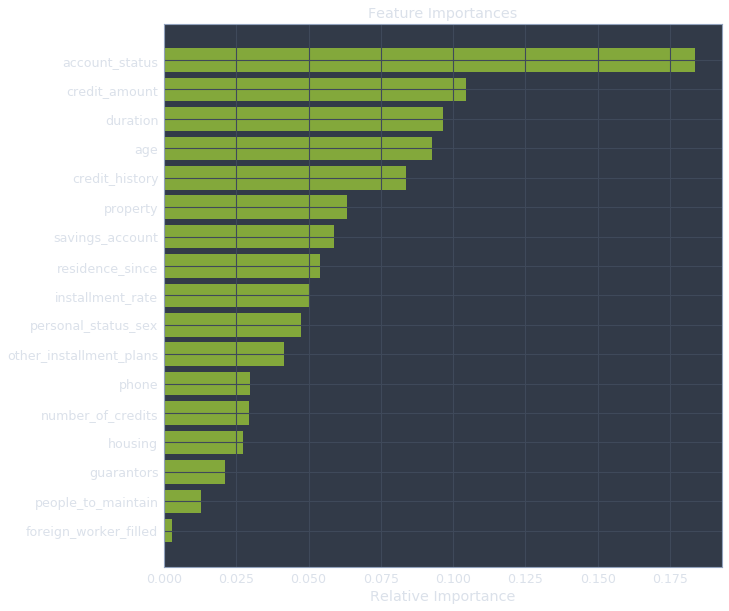

In [49]:
# Add foreign Worker feature to classification
display_feature_importance(clf)

## Feature Engineering



In [50]:
def replace_features(df, col_name, replace_to):
    old_enc = list(df[col_name].unique())
    old_enc.remove(np.nan)
    old_enc = sorted(old_enc)

    # change to "emplayed for more than"
    new_enc = replace_to
    df_new_enc = df.replace(old_enc, new_enc)
    return df_new_enc

def compare_replaced_features(df, col_name, exchange_dict,
                         classifiers, classifier_names, df_X_onehot):

    
    for k,v in exchange_dict.items():
        print('\n\n', k)
        df_enc = replace_features(df, col_name, v)
        compare_classifiers(classifiers, classifier_names, [col_name], df_enc, 
                        df_X_onehot)
        
    return



In [51]:
job_replace_to = {
        'Ordinal from 0 to 3' : [0, 1, 2, 3],
        'unemployed/ unskilled = 0, skilled employee / official management/ self-employed/ = 1' : [0, 0, 1, 1],
        'unemployed = 0, else = 1' : [0, 1, 1, 1]
    }

compare_replaced_features(df, 'job', job_replace_to,
                         classifiers, classifier_names, df_X_onehot)



 Ordinal from 0 to 3


Linear Classification for featuren "job"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.58 (+/- 0.15)
Cross Validation f1_micro: 0.56 (+/- 0.12)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.64 (+/- 0.03)
Cross Validation f1_micro: 0.64 (+/- 0.03)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.64 (+/- 0.03)
Cross Validation f1_micro: 0.64 (+/- 0.03)


 unemployed/ unskilled = 0, skilled employee / official management/ self-employed/ = 1


Linear Classification for featuren "job"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.78 (+/- 0.03)
Cross Validation f1_micro: 0.76 (+/- 0.08)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.80 (+/- 0.02)
Cross Validation f1_micro: 0.80 (+/- 0.02)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.79 (+/- 0.02)
Cross Validation f1_micro: 0.79 (+/- 0.02)


 unemployed = 0, else = 1


Linear Classification for featuren "job"

Classifier: SGDClassifier 

LinearSVC(multi_class="crammer_singer" for job:   

Cross Validation accuracy: 0.64 (+/- 0.03)   
Cross Validation f1_micro: 0.64 (+/- 0.03)

Great! Binarising the feature helps to classify between unemployed / employed. Now the column can be predicted and added to the data.

In [52]:
df_job = replace_features(df, "job", [0, 1, 1, 1])

In [53]:
def ridge_grid_search(df_with_na, df_X, target_col):
    
    _, X_train, y_train, X_test = split_data_missing_vals(
        df_with_na, df_X, target_col)

    # prepare a range of alpha values to test
    params = {'solver': ['auto', 'svd', 'lsqr'],
             'alpha': [1,0.1,0.01,0.001,0.0001,0]}
    # create and fit a ridge regression model, testing each alpha
    model = RidgeClassifier()
    
    # optimised by cross-validated grid-search over a parameter grid.
    grid = GridSearchCV(estimator=model, param_grid=params)
    grid.fit(X_train, y_train)
    # summarize the results of the grid search
    print(f'Best Score: {grid.best_score_}')
    print(f'Best alpha: {grid.best_estimator_.alpha}')
    print(f'Best solver: {grid.best_estimator_.solver}')
    
    return grid.best_estimator_

In [54]:
clf = ridge_grid_search(df_job, df_X_onehot, 'job')

col_job = predict_column(
    clf, df_job, df_X_enc, "job")
filled_cols['job_filled'] = col_job
missing_columns.remove('job')

df_X_onehot = (pd.concat([df_X_onehot, filled_cols['job_filled']], axis=1))
df_X_enc = (pd.concat([df_X_enc, col_job], axis=1))

Best Score: 0.9791666666666666
Best alpha: 1
Best solver: auto
Training a RidgeClassifier with a training set size of 768


_Random Forest with Foreign Worker and Job_


Training a RandomForestClassifier with a training set size of 1050
Test Precision Score: 0.8022598870056498
Test Accuracy Score: 0.7885714285714286
Test Confusion Matrix: 
 [[134  35]
 [ 39 142]]
Number of False Positives: 35

 Feature Importance, sums up to 1:
('account_status', 0.16778850172126888)
('credit_history', 0.09392065071854687)
('savings_account', 0.06337982609485215)
('personal_status_sex', 0.047888323530460034)
('guarantors', 0.02034288539717752)
('property', 0.053015658556458865)
('other_installment_plans', 0.044306890449727285)
('housing', 0.030014983227869885)
('duration', 0.10382180692939733)
('credit_amount', 0.11516759746288019)
('installment_rate', 0.04706392274092523)
('residence_since', 0.05867874027330892)
('age', 0.08396261728207262)
('number_of_credits', 0.02649257370899415)
('people_to_maintain', 0.013696281215168107)
('phone', 0.022156094284689322)
('foreign_worker_filled', 0.0040063601890671105)
('job', 0.0042962862171355455)


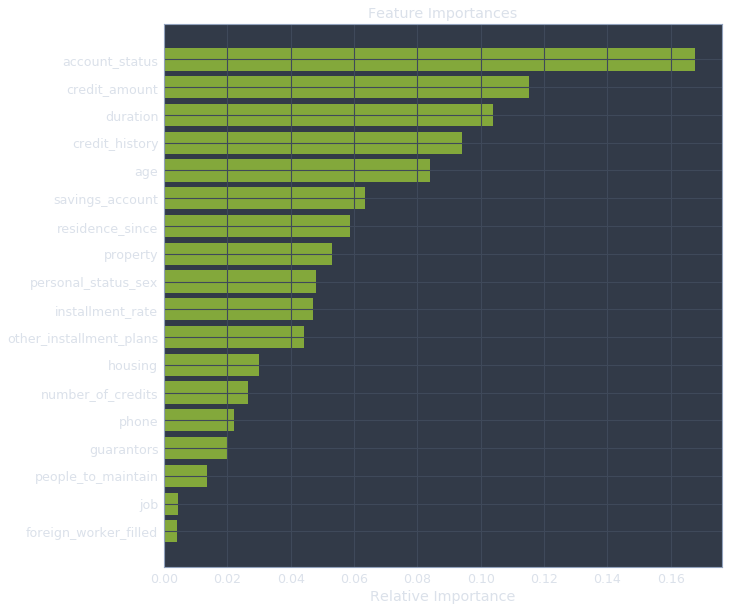

In [55]:
# Add foreign Worker feature to classification
# Thry the classifier with additional feature
X_train, X_test, y_train, y_test = train_test_split(
    df_X_enc, label_enc, test_size = 0.25, random_state=4)

clf = RandomForestClassifier()
y_pred = train_predict(clf, X_train, y_train, X_test, y_test=None)
evaluate_test(y_test, y_pred)
display_feature_importance(clf)

### Employment Since

In [56]:
empl_since_replace_to = {
        'Employed at least n years' : [0, 1, 1, 4, 7],
        'Employed at most n years' : [0, 1, 4, 7, 50],
        'Employed more than a year' : [0, 0, 1, 1, 1],
        'Employed more than 4 years' : [0, 0, 0, 1, 1],
        'Employed more than 7 years' : [0, 0, 0, 1, 1]
    }

compare_replaced_features(df, 'employment_since', empl_since_replace_to,
                         classifiers, classifier_names, df_X_onehot)



 Employed at least n years


Linear Classification for featuren "employment_since"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.49 (+/- 0.08)
Cross Validation f1_micro: 0.42 (+/- 0.11)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.57 (+/- 0.06)
Cross Validation f1_micro: 0.57 (+/- 0.06)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.55 (+/- 0.05)
Cross Validation f1_micro: 0.55 (+/- 0.05)


 Employed at most n years


Linear Classification for featuren "employment_since"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.33 (+/- 0.03)
Cross Validation f1_micro: 0.34 (+/- 0.06)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.39 (+/- 0.06)
Cross Validation f1_micro: 0.39 (+/- 0.06)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.40 (+/- 0.05)
Cross Validation f1_micro: 0.40 (+/- 0.05)


 Employed more than a year


Linear Classification for featuren "employment_since"

Classifier: SGDClassifier 

Cross Validat

Employed more than a year
Cross Validation accuracy: 0.77 (+/- 0.02)
Cross Validation f1_micro: 0.70 (+/- 0.13)

In [57]:
df_empl_since = replace_features(df, 'employment_since', [0, 0, 1, 1, 1])

clf = ridge_grid_search(df_empl_since, df_X_onehot, 'employment_since')

col_empl_since = predict_column(
    clf, df_empl_since, df_X_onehot, 'employment_since')
filled_cols['employment_since_filled'] = col_empl_since
missing_columns.remove('employment_since')


df_X_onehot = (pd.concat([df_X_onehot, col_empl_since], axis=1))
df_X_enc = (pd.concat([df_X_enc, col_empl_since], axis=1))

Best Score: 0.7718253968253969
Best alpha: 0.1
Best solver: auto
Training a RidgeClassifier with a training set size of 504


In [58]:
df_X_enc.shape

(1400, 19)

Training a RandomForestClassifier with a training set size of 1050
Test Precision Score: 0.8658536585365854
Test Accuracy Score: 0.8257142857142857
Test Confusion Matrix: 
 [[147  22]
 [ 39 142]]
Number of False Positives: 22

 Feature Importance, sums up to 1:
('account_status', 0.20130338475669354)
('credit_history', 0.06412306530652549)
('savings_account', 0.042316242811002935)
('personal_status_sex', 0.043554092236785066)
('guarantors', 0.017630654650662922)
('property', 0.07539043446192459)
('other_installment_plans', 0.034992651114475005)
('housing', 0.033453658707793696)
('duration', 0.09758741290171037)
('credit_amount', 0.11554975540977871)
('installment_rate', 0.055641384719545814)
('residence_since', 0.055547132901315986)
('age', 0.06996143286827342)
('number_of_credits', 0.025674887626399318)
('people_to_maintain', 0.018129821639876167)
('phone', 0.030070612280226484)
('foreign_worker_filled', 0.0033090532094719855)
('job', 0.005246101014743802)
('employment_since', 0.01051

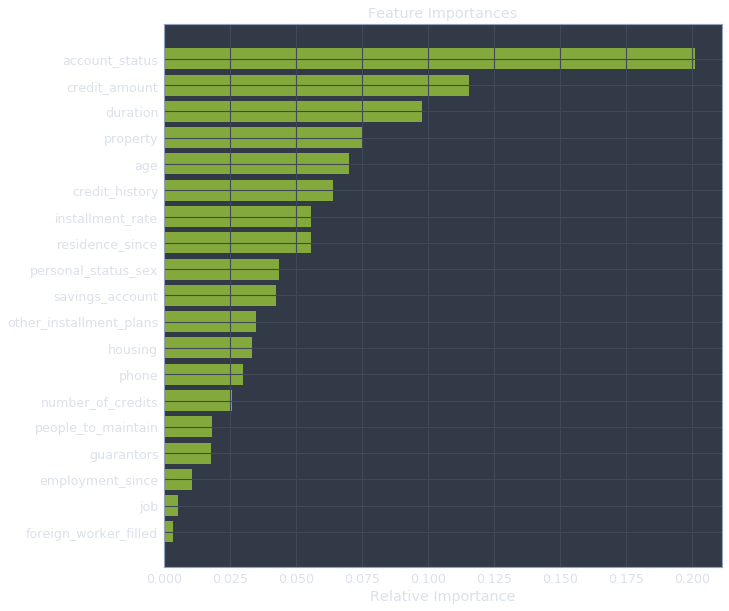

In [59]:
# Foreign, Job, Empl_since
# Add foreign Worker feature to classification
# Thry the classifier with additional feature
X_train, X_test, y_train, y_test = train_test_split(
    df_X_enc, label_enc, test_size = 0.25, random_state=4)

clf = RandomForestClassifier()
y_pred = train_predict(clf, X_train, y_train, X_test, y_test=None)
evaluate_test(y_test, y_pred)
display_feature_importance(clf)

*Purpose*

In [60]:
#The are many features available. 
print('Number of non-na values: ', df['purpose'].count())
print(df['purpose'].unique())

col_purpose = df['purpose'].fillna('missing')
col_purpose = encode_target_var(col_purpose, method = 'onehot')
pd.Series(col_purpose).unique()

compare_classifiers(classifiers, classifier_names, missing_columns, df, df_X_onehot)
# filled_cols['purpose_filled'] = col_purpose

Number of non-na values:  827
[nan 'A46' 'A40' 'A43' 'A41' 'A42' 'A49' 'A410' 'A45' 'A48' 'A44']


Linear Classification for featuren "purpose"

Classifier: SGDClassifier 

Cross Validation accuracy: 0.26 (+/- 0.04)
Cross Validation f1_micro: 0.25 (+/- 0.09)

Classifier: RidgeClassifier 

Cross Validation accuracy: 0.35 (+/- 0.06)
Cross Validation f1_micro: 0.35 (+/- 0.06)

Classifier: LogisticRegression 

Cross Validation accuracy: 0.35 (+/- 0.05)
Cross Validation f1_micro: 0.35 (+/- 0.05)


In [61]:
# make sure that the filled df has the same dimensions as the original df
print(df_X_enc.shape)
df_X_onehot.shape

(1400, 19)


(1400, 42)

### Correlation Matrix between features

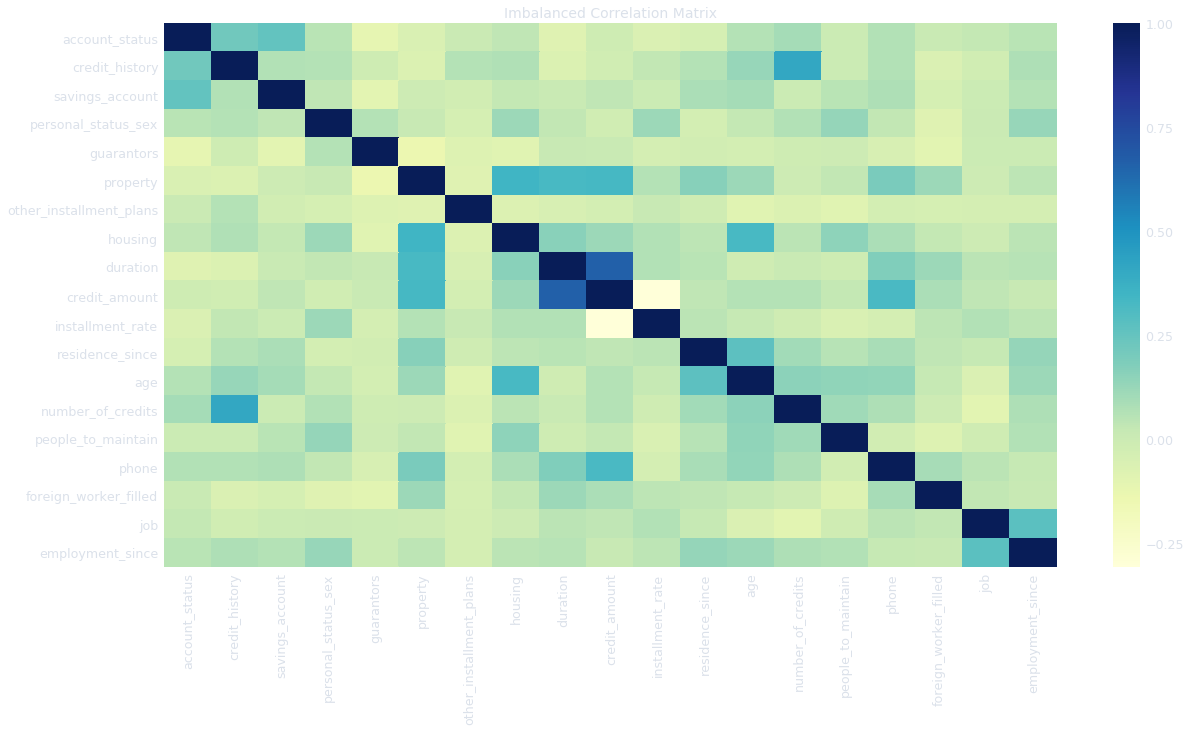

In [62]:
def plot_corr_matrix(df):
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(20,10))         
    # Imbalanced DataFrame Correlation
    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
    plt.show()
    return

plot_corr_matrix(df_X_enc)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  2.9min finished


Best Score: 0.8505490857946554
Best Params: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10}
Training a RandomForestClassifier with a training set size of 1050
Test Precision Score: 0.8225806451612904
Test Accuracy Score: 0.7371428571428571
Test Confusion Matrix: 
 [[156  22]
 [ 70 102]]
Number of False Positives: 22

 Feature Importance, sums up to 1:
('account_status', 0.5660639175507126)
('credit_history', 0.08260328745408764)
('savings_account', 0.08424737449746907)
('personal_status_sex', 0.008718100169747245)
('guarantors', 0.009754036153728926)
('property', 0.025326854916536592)
('other_installment_plans', 0.054076117647283914)
('housing', 0.03684098930355944)
('duration', 0.03908621138510813)
('credit_amount', 0.03336569774783866)
('installment_rate', 0.017109324547154848)
('residence_since', 0.020076075758195464)
('age', 0.0030130369667671296)
('number_of_credits', 0.0057636856303551086)
('people_to_maintain', 0.0)
('phone', 0.00643775232137128

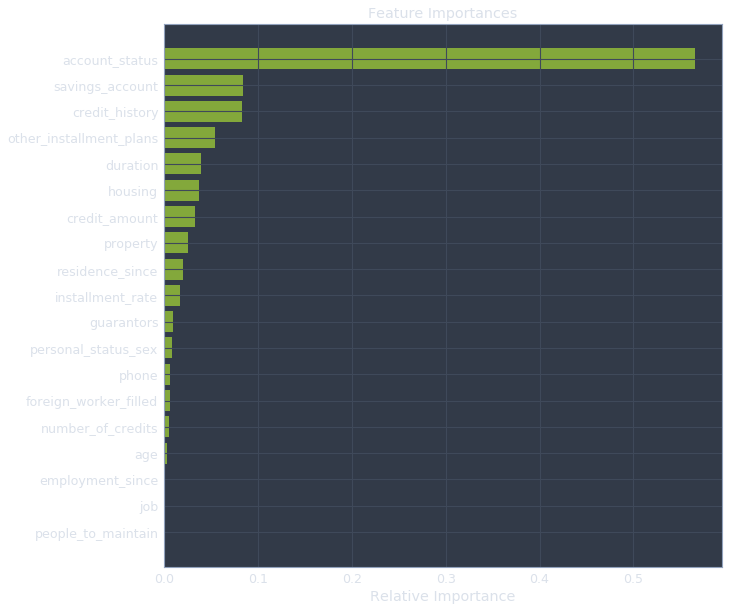

In [63]:
# Foreign, Job, Empl_since
# Add foreign Worker feature to classification
# Thry the classifier with additional feature
X_train, X_test, y_train, y_test = train_test_split(
    df_X_enc, label_enc, test_size = 0.25, random_state=1)

clf = randomforestclf_grid_search(X_train, y_train, X_test, y_test)

y_pred = train_predict(clf, X_train, y_train, X_test, y_test=None)
evaluate_test(y_test, y_pred)
display_feature_importance(clf)


In [64]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization by class can be applied by setting `normalize=True`.
    This kind of normalization can be interesting in case of class
    imbalance to have a more visual interpretation of which class is being misclassified.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[156  22]
 [ 70 102]]

Normalized confusion matrix
[[0.87640449 0.12359551]
 [0.40697674 0.59302326]]


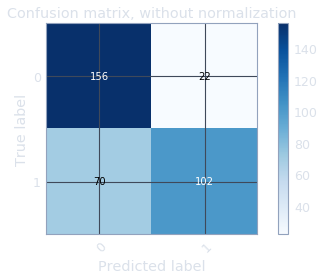

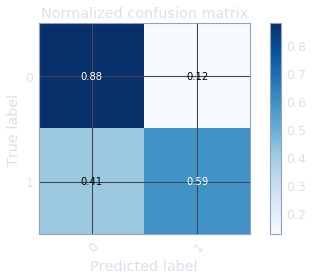

In [66]:
plot_confusion_matrix(list(y_test), list(y_pred), np.array([0, 1]))
plot_confusion_matrix(list(y_test), list(y_pred), np.array([0, 1]), normalize=True)

In [67]:
def try_other_classifier(clf, X_train, y_train, X_test, y_test):
    y_pred = train_predict(clf, X_train, y_train, X_test, y_test)
    evaluate_test(y_test, y_pred)
    plot_confusion_matrix(list(y_test), list(y_pred), np.array([0, 1]))
    plot_confusion_matrix(list(y_test), list(y_pred), np.array([0, 1]), normalize=True)

Training a SVC with a training set size of 1050
Test Precision Score: 0.8246753246753247
Test Accuracy Score: 0.7942857142857143
Test Confusion Matrix: 
 [[151  27]
 [ 45 127]]
Number of False Positives: 27
Confusion matrix, without normalization
[[151  27]
 [ 45 127]]

Normalized confusion matrix
[[0.84831461 0.15168539]
 [0.26162791 0.73837209]]


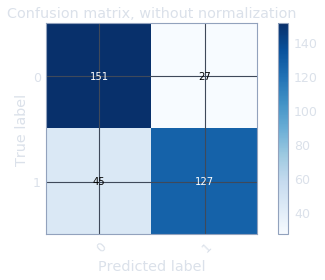

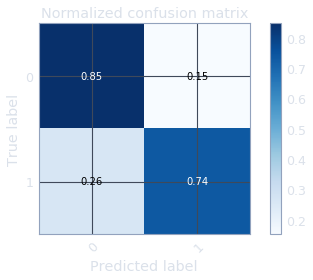

In [68]:
clf_svm = SVC(random_state = 9, kernel='rbf')
try_other_classifier(clf_svm, X_train, y_train, X_test, y_test)

Training a SVC with a training set size of 1050
Test Precision Score: 0.7218543046357616
Test Accuracy Score: 0.7
Test Confusion Matrix: 
 [[136  42]
 [ 63 109]]
Number of False Positives: 42
Confusion matrix, without normalization
[[136  42]
 [ 63 109]]

Normalized confusion matrix
[[0.76404494 0.23595506]
 [0.36627907 0.63372093]]


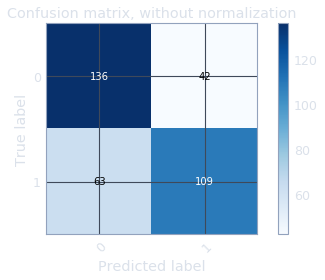

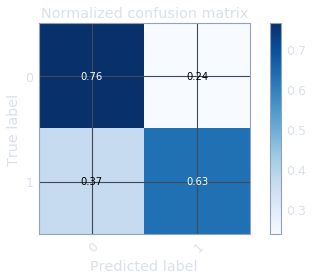

In [69]:
clf_svm = SVC(random_state = 9, kernel='linear')
try_other_classifier(clf_svm, X_train, y_train, X_test, y_test)

Training a LogisticRegression with a training set size of 1050
Test Precision Score: 0.7204968944099379
Test Accuracy Score: 0.7114285714285714
Test Confusion Matrix: 
 [[133  45]
 [ 56 116]]
Number of False Positives: 45
Confusion matrix, without normalization
[[133  45]
 [ 56 116]]

Normalized confusion matrix
[[0.74719101 0.25280899]
 [0.3255814  0.6744186 ]]


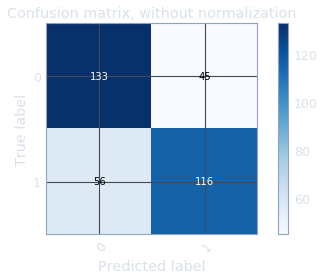

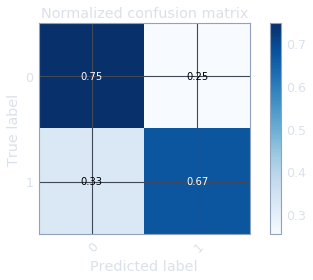

In [70]:
clf_log_reg = LogisticRegression()
try_other_classifier(clf_log_reg, X_train, y_train, X_test, y_test)

Training a ExtraTreesClassifier with a training set size of 1050
Test Precision Score: 0.8609271523178808
Test Accuracy Score: 0.82
Test Confusion Matrix: 
 [[157  21]
 [ 42 130]]
Number of False Positives: 21
Confusion matrix, without normalization
[[157  21]
 [ 42 130]]

Normalized confusion matrix
[[0.88202247 0.11797753]
 [0.24418605 0.75581395]]


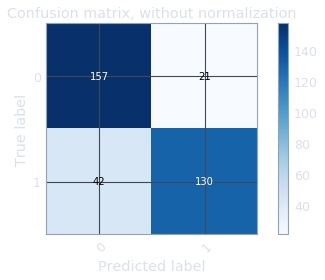

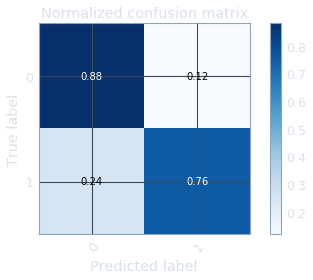

In [71]:
clf_extra = ExtraTreesClassifier()
try_other_classifier(clf_extra, X_train, y_train, X_test, y_test)